<a href="https://colab.research.google.com/github/santhoshjinna15/INFO5731/blob/main/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [34]:
# Write your code here

import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [36]:

!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (3.8.3)


In [37]:
import spacy.cli
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [39]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

     |████████████████████████████████| 1.7MB 5.5MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=2ef6cd66c3d35911469460dc96a3a01d7c70a9c66469713e8be918145e160a5a
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [41]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [42]:

import pandas as pd
from google.colab import files
uploaded = files.upload()



Saving Tittle_Author.csv to Tittle_Author (1).csv


In [43]:
df= pd.read_csv("Tittle_Author.csv")
#display only 10
df.head(5)

,Unnamed: 0,Tag,Name,Title,Body,Upvotes,Date,Comments,Link
0,0,Artificial Intelligence,WiseWolf Fund,GAME-CHANGING TRENDS TO LOOK OUT FOR WITH AI,Artificial Intelligence is a state-of-the-art ...,12.9K,30-Apr,10 responses,https://medium.com/@wisewolf_fund/unique-trend...
1,1,Artificial Intelligence,Justin Lee,Chatbots were the next big thing: what happened?,"Oh, how the headlines blared:“…the 2016 bot",7.7K,5-Jun,41 responses,https://medium.com/swlh/chatbots-were-the-next...
2,2,Artificial Intelligence,Emmanuel Ameisen,Reinforcement Learning from scratch,Inspired by a great tutorial at O’Reilly AI,907,7-Jun,1 response,https://blog.insightdatascience.com/reinforcem...
3,3,Artificial Intelligence,Irhum Shafkat,Intuitively Understanding Convolutions for Dee...,Exploring the strong visual hierarchies that,1.92K,1-Jun,2 responses,https://towardsdatascience.com/intuitively-und...
4,4,Artificial Intelligence,Sam Drozdov,An intro to Machine Learning for designers,The basics of machine learning and how to appl...,2.3K,30-May,10 responses,https://uxdesign.cc/an-intro-to-machine-learni...


In [44]:
data = df['Title'].tolist()

In [45]:
data_words = []
for line in data:
  data_words.append(gensim.utils.simple_preprocess(str(line), deacc=True))

In [46]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [47]:
after_stopword_removal = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_words]
bigrams = [bigram_mod[doc] for doc in after_stopword_removal]

In [48]:
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
after_lemmatization = []
for sent in bigrams:
  doc = nlp(" ".join(sent)) 
  after_lemmatization.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])


Building Dictionary, Corpus and Term Document Frequency

In [49]:
id2word = corpora.Dictionary(after_lemmatization)
texts = after_lemmatization
corpus = [id2word.doc2bow(text) for text in after_lemmatization]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [50]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ai', 1), ('change', 1), ('game', 1), ('look', 1), ('trend', 1)]]


Building LDA Model with 20 topics

In [51]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


Compute Model Perplexity and Coherence Score

In [52]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=after_lemmatization, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.649209257001164

Coherence Score:  0.47739571383028023



Setting environment Path and giving Mallet Path

In [74]:

import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()


openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [75]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-03-19 20:40:50--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  17.7MB/s    in 0.9s    

2021-03-19 20:40:51 (17.7 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

Building LDA Mallet Model

In [76]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=13, id2word=id2word)


Compute Coherence Value for LDA

In [77]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [79]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=after_lemmatization, start=2, limit=60, step=6)

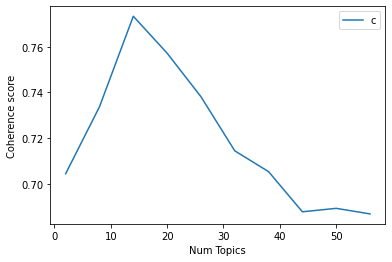

In [80]:

limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [81]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.7044
Num Topics: 8  - Coherence Value: 0.7337
Num Topics: 14  - Coherence Value: 0.7734
Num Topics: 20  - Coherence Value: 0.7572
Num Topics: 26  - Coherence Value: 0.7381
Num Topics: 32  - Coherence Value: 0.7144
Num Topics: 38  - Coherence Value: 0.7053
Num Topics: 44  - Coherence Value: 0.6877
Num Topics: 50  - Coherence Value: 0.6892
Num Topics: 56  - Coherence Value: 0.6867


In [82]:

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


Printing Topics

In [83]:

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.127*"datum" + 0.127*"science" + 0.035*"job" + 0.035*"scientist" + '
  '0.035*"do" + 0.030*"sauce" + 0.030*"secret" + 0.030*"startup" + '
  '0.019*"many" + 0.019*"leader"'),
 (1,
  '0.124*"build" + 0.113*"neural" + 0.076*"network" + 0.044*"play" + '
  '0.044*"deep" + 0.037*"scratch" + 0.034*"accurate" + 0.034*"counter" + '
  '0.034*"labor" + 0.034*"manual"'),
 (2,
  '0.083*"artificial" + 0.067*"intelligence" + 0.053*"model" + '
  '0.053*"learning" + 0.050*"translation" + 0.050*"difference" + '
  '0.039*"machine" + 0.037*"learn" + 0.037*"deep" + 0.037*"music"'),
 (3,
  '0.096*"learning" + 0.096*"deep" + 0.069*"base" + 0.048*"monitoring" + '
  '0.048*"easily" + 0.048*"drone" + 0.048*"girl" + 0.048*"draw" + 0.048*"use" '
  '+ 0.023*"mining"'),
 (4,
  '0.101*"course" + 0.057*"learn" + 0.038*"internet" + 0.038*"review" + '
  '0.038*"rank" + 0.038*"single" + 0.038*"machine" + 0.033*"do" + '
  '0.033*"friend" + 0.033*"stay"'),
 (5,
  '0.089*"scientist" + 0.068*"data" + 0.057*"company


Topic Visualization

In [84]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.195724 -0.010786       1        1  20.215980
7     -0.007099 -0.178614       2        1  10.395056
12     0.086272 -0.161140       3        1   8.890976
8      0.049768  0.032176       4        1   8.286444
9      0.057679 -0.084570       5        1   8.232378
2      0.099478 -0.003696       6        1   7.761242
10    -0.051097  0.075036       7        1   6.446483
5     -0.200391 -0.068072       8        1   6.443163
1     -0.095192  0.094092       9        1   5.939885
3      0.087375  0.153408      10        1   5.060579
11     0.062322  0.110390      11        1   4.899565
0     -0.162996 -0.002039      12        1   3.486918
4     -0.055646 -0.016736      13        1   3.098865
6     -0.066197  0.060551      14        1   0.842464, topic_info=        Term       Freq      Total Category  logprob  loglift
50     datum  15.000000  15.000000  Default  30.0000  30.0000
10  learning  46.000000  46.000000  Default  29.0000  29.0000
18   machine  40.000000  40.000000  Default  28.0000  28.0000
39    neural  12.000000  12.000000  Default  27.0000  27.0000
38     build   7.000000   7.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
23     start   0.023578   4.858831  Topic14  -5.7393  -0.5516
24        up   0.023578   2.888322  Topic14  -5.7393  -0.0315
25       art   0.023578   3.115544  Topic14  -5.7393  -0.1072
26      fifa   0.023578   3.115544  Topic14  -5.7393  -0.1072
27      free   0.023578   3.115544  Topic14  -5.7393  -0.1072

[600 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
125       4  0.870372  accuracy
198       9  0.817216  accurate
0         1  0.121740        ai
0         2  0.486961        ai
0         4  0.243480        ai
...     ...       ...       ...
163       3  0.757918      word
268      13  0.641633  workflow
194       1  0.550241      wwdc
183       4  0.835274      year
69        7  0.512959       yet

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 8, 13, 9, 10, 3, 11, 6, 2, 4, 12, 1, 5, 7])

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python


Importing LSA model

In [86]:
# Write your code here

from gensim.models import LsiModel


Bulding Model

In [87]:
lsamodel = LsiModel(corpus, 20, id2word)


Computing coherence value for LSA

In [89]:
def compute_coherence_values_lsi(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

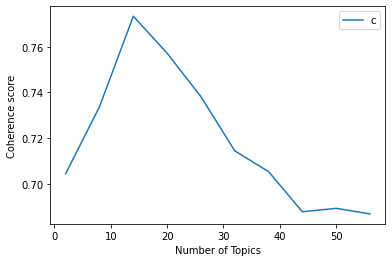

In [90]:
start,stop,step=2,60,6
model_list_lsa, coherence_values_lsa = compute_coherence_values_lsi(id2word, corpus,after_lemmatization,stop, start, step)
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [91]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values_lsa):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.4868
Num Topics: 8  - Coherence Value: 0.4702
Num Topics: 14  - Coherence Value: 0.4851
Num Topics: 20  - Coherence Value: 0.4749
Num Topics: 26  - Coherence Value: 0.4788
Num Topics: 32  - Coherence Value: 0.4938
Num Topics: 38  - Coherence Value: 0.4657
Num Topics: 44  - Coherence Value: 0.474
Num Topics: 50  - Coherence Value: 0.4785
Num Topics: 56  - Coherence Value: 0.4907


Printing Topics

In [92]:
pprint(lsamodel.print_topics())

[(0,
  '-0.530*"learn" + -0.439*"learning" + -0.436*"machine" + -0.434*"deep" + '
  '-0.170*"part" + -0.127*"neural" + -0.124*"network" + -0.119*"datum" + '
  '-0.083*"ai" + -0.077*"use"'),
 (1,
  '-0.650*"learning" + 0.521*"learn" + -0.277*"machine" + 0.189*"neural" + '
  '0.179*"network" + 0.158*"ai" + 0.106*"datum" + 0.093*"big" + 0.088*"sheet" '
  '+ 0.083*"deep"'),
 (2,
  '-0.619*"deep" + 0.565*"machine" + -0.180*"use" + 0.177*"learn" + '
  '-0.166*"learning" + 0.136*"part" + -0.118*"easily" + 0.101*"datum" + '
  '-0.085*"base" + -0.083*"monitoring"'),
 (3,
  '0.473*"neural" + 0.396*"network" + 0.286*"part" + 0.269*"reinforcement" + '
  '0.233*"tensorflow" + -0.229*"machine" + 0.204*"build" + 0.200*"table" + '
  '0.200*"simple" + 0.188*"learning"'),
 (4,
  '0.714*"datum" + 0.303*"science" + 0.283*"scientist" + -0.183*"part" + '
  '-0.180*"learn" + 0.114*"data" + 0.106*"need" + 0.099*"big" + 0.097*"master" '
  '+ 0.097*"statistical"'),
 (5,
  '-0.795*"regression" + -0.282*"linear" 


Summarized topics

Reinforcement Learning fromÂ scratch

Every single Machine Learning course on the internet, ranked by yourÂ reviews

The Current Best of Universal Word Embeddings and Sentence Embeddings

Machine Learning is Fun! Part 4: Modern Face Recognition with DeepÂ Learning

The Big List of DS/ML Interview Resources

The Difference Between Artificial Intelligence, Machine Learning, and DeepÂ Learning

TensorFlow Estimator & DatasetÂ APIs




## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)

LSA ( Latent Semantic Analysis )

LSA is used for identifying themes in database of text. The core idea is to convert the data to matrix which contains the terms and the topics. Based on the matric we can effectively perform Topic modelling by decomposing the terms to a seperate topic-term matrix and document-term matrix. We acheived a choherance score around .49

LDA ( Latent Dirichlet Allocation )

LDA is used for solving topic modelling problems. The core idea is to process the document term matrix and the topic term matrix and perfom the topic modelling. LDA uses the training data set and learns from the Unstructured groups. So most of the topics are quite similar. We acheived coherence score around .78

We got more number of topics for LDA than LSA with more coherence score. The increase in coherence scores gives the increase in effeciency. Hence we can say that LDA is better for topic modelling . In real case scenario also LSA mainly focuses on dimentionality reduction